In [30]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

import concurrent.futures

from numba import jit
from numba.experimental import jitclass

from scipy.stats import skew

from functools import partial

### Data Preparation

In [31]:
def compute_log_returns(df):
    log_df = np.log(df)
    log_returns = log_df.diff()

    return log_returns

In [32]:
# we load the datasets
ftse = pd.read_csv("C:\\Users\\Saverio\\Documents\\GitHub\\python_defi_project\\data\\ftse100.csv", dtype = float, parse_dates= True, index_col= 0)
hanseng = pd.read_csv("C:\\Users\\Saverio\\Documents\\GitHub\\python_defi_project\\data\\hanseng.csv", dtype = float, parse_dates= True, index_col= 0)
sp =  pd.read_csv("C:\\Users\\Saverio\\Documents\\GitHub\\python_defi_project\\data\\sp100.csv", dtype = float, parse_dates= True, index_col= 0)

# we calculate the log returns
ftse_rets = compute_log_returns(ftse).dropna()
hanseng_rets = compute_log_returns(hanseng).dropna()
sp_rets = compute_log_returns(sp).dropna()

(ftse_rets.shape, hanseng_rets.shape, sp_rets.shape)

((520, 56), (454, 30), (503, 75))

### Genetic Algorithm Set-Up

In [33]:
### Bottleneck functions to optimize with numba to speed up the code

@jit(nopython=True, cache=True)
def repair_weights(weights, min_holding_constraint, max_holding_constraint):

        max_loops = 100

        repaired_weights = np.copy(weights)

        for i in range(max_loops):

            too_high_mask = repaired_weights > max_holding_constraint
            too_low_mask = repaired_weights < min_holding_constraint

            if not np.any(too_high_mask) and not np.any(too_low_mask):
                break

            excess = np.sum(repaired_weights[too_high_mask] - max_holding_constraint)
            deficit = np.sum(min_holding_constraint - repaired_weights[too_low_mask])

            repaired_weights[too_high_mask] = max_holding_constraint
            repaired_weights[too_low_mask] = min_holding_constraint

            eligible_mask = ~(too_high_mask | too_low_mask)

            if not np.any(eligible_mask):
                break

            net_change = excess - deficit

            eligible_weights = repaired_weights[eligible_mask]
            
            adjustment = net_change * (eligible_weights / np.sum(eligible_weights))
            repaired_weights[eligible_mask] -= adjustment
        
        return repaired_weights / np.sum(repaired_weights)

@jit(nopython=True, cache=True)
def compute_weights(s_list, K, min_holding_constraint, max_holding_constraint):
    
    weights_vector = np.full(K, min_holding_constraint)
    left_over_asset_share = 1.0 - (K * min_holding_constraint)

    sum_s = np.sum(s_list)

    if sum_s > 0:
        normalized_s_vector = s_list / sum_s
        final_weights = weights_vector + left_over_asset_share * normalized_s_vector
        return repair_weights(final_weights, min_holding_constraint, max_holding_constraint)
    else:
        return weights_vector / np.sum(weights_vector)

### Here we enhance the efficiency of some parts of the fitness calculation function

@jit(nopython=True, cache=True)
def calculate_mad_fitness(portfolio_returns, trade_off_param):
    portfolio_expected_return = np.mean(portfolio_returns)
    risk_metric = np.mean(np.abs(portfolio_returns - portfolio_expected_return))
    fitness = trade_off_param * risk_metric - (1.0 - trade_off_param) * portfolio_expected_return
    return fitness, risk_metric, portfolio_expected_return

@jit(nopython=True, cache=True)
def calculate_semivariance_fitness(portfolio_returns, trade_off_param):
    portfolio_expected_return = np.mean(portfolio_returns)
    deviations = portfolio_returns - portfolio_expected_return
    # Numba requires a loop for this kind of conditional logic
    sum_sq_dev = 0.0
    for dev in deviations:
        if dev < 0:
            sum_sq_dev += dev**2
    risk_metric = sum_sq_dev / len(portfolio_returns)
    fitness = trade_off_param * risk_metric - (1.0 - trade_off_param) * portfolio_expected_return
    return fitness, risk_metric, portfolio_expected_return

### Here we write some support functions to speed up the crossover and mutation function

@jit(nopython=True, cache=True)
def assign_s_values(child_asset_indices, 
                        p1_indices, p1_s_values, 
                        p2_indices, p2_s_values):

    final_child_s_values = np.zeros(len(child_asset_indices), dtype=np.float64)

    for i in range(len(child_asset_indices)):
        asset = child_asset_indices[i]
        
        # Search for the asset in parents
        is_in_p1 = False
        idx1 = -1
        for j in range(len(p1_indices)):
            if p1_indices[j] == asset:
                is_in_p1 = True
                idx1 = j
                break
        
        is_in_p2 = False
        idx2 = -1
        for j in range(len(p2_indices)):
            if p2_indices[j] == asset:
                is_in_p2 = True
                idx2 = j
                break

        if is_in_p1 and is_in_p2: # Common asset
            final_child_s_values[i] = p1_s_values[idx1] if np.random.rand() < 0.5 else p2_s_values[idx2]
        elif is_in_p1: # From parent 1 only
            final_child_s_values[i] = p1_s_values[idx1]
        elif is_in_p2: # From parent 2 only
            final_child_s_values[i] = p2_s_values[idx2]
        else: # Newly added asset (should not happen if called correctly, but as a fallback)
            final_child_s_values[i] = np.random.rand()
            
    return final_child_s_values



In [34]:
class GA_PortfolioOptimization:

    class Chromosome:
        def __init__(self, asset_indices, s_list):

            self.asset_indices = asset_indices
            self.s_list = s_list

            self.fitness = None
            self.weights = None

            self.expected_return = None
            self.risk_factor = None


    def __init__(self, assets_returns_df, K, min_holding_constraint, max_holding_constraint):

        self.asset_returns = assets_returns_df
        self.assets_list = assets_returns_df.columns
        self.expected_returns = assets_returns_df.mean()
        self.var_cov_matrix = assets_returns_df.cov()   

        self.asset_returns_numpy = self.asset_returns.values
        self.expected_returns_numpy = self.expected_returns.values
        self.var_cov_matrix_numpy = self.var_cov_matrix.values

        self.assets_indices = np.arange(assets_returns_df.shape[1])
        self.K = K     
       
    
        # We assume a minimum and maximum holding constraint
        self.min_holding_constraint = min_holding_constraint
        self.max_holding_constraint = max_holding_constraint

        self.trade_off_param = None
        self.weight_skewness = None

        self.asset_map = {name: i for i, name in enumerate(assets_returns_df.columns)}

    def create_chromosome(self):                
        asset_indices = np.random.choice(self.assets_indices, size=self.K, replace=False)
        s_list = np.random.uniform(0, 1, size=self.K)
  
        return self.Chromosome(asset_indices=asset_indices, s_list=s_list)

    def fitness_function_mean_variance(self, chromosome):

        weights = chromosome.weights 
        asset_indices = chromosome.asset_indices

        means = self.expected_returns_numpy[asset_indices]
        covariances = self.var_cov_matrix_numpy[np.ix_(asset_indices, asset_indices)]

        var_term = weights.T @ covariances @ weights
        mean_term = weights @ means

        chromosome.risk_factor = var_term
        chromosome.expected_return = mean_term

        fitness = self.trade_off_param * var_term - (1 - self.trade_off_param) * mean_term
        
        return fitness
    
    def fitness_function(self, chromosome, risk_term):
        
        weights = chromosome.weights
        asset_indices = chromosome.asset_indices

        time_series = self.asset_returns_numpy[:, asset_indices]
        
        portfolio_returns = time_series@weights
        portfolio_expected_return = np.mean(portfolio_returns)

        risk_metric = None
        fitness = None        

        if risk_term == "MAD":
            fitness, risk, ret = calculate_mad_fitness(portfolio_returns, self.trade_off_param)

            chromosome.fitness = fitness
            chromosome.risk_factor = risk
            chromosome.expected_return = ret

        elif risk_term == "semivariance":

            fitness, risk, ret = calculate_semivariance_fitness(portfolio_returns, self.trade_off_param)
            chromosome.fitness = fitness
            chromosome.risk_factor = risk
            chromosome.expected_return = ret
        
        elif risk_term == "skewness":
            ret = np.mean(portfolio_returns)
            risk = np.var(portfolio_returns)
            skew_val = skew(portfolio_returns) # Scipy call
            
            chromosome.expected_return = ret
            chromosome.risk_factor = risk
            chromosome.fitness = self.trade_off_param * risk - (1 - self.trade_off_param) * ret - self.weight_skewness * skew_val


        elif risk_term == "MV":
            fitness = self.fitness_function_mean_variance(chromosome)  

            chromosome.fitness =fitness

        else:
            print("Enter a valid argument for 'risk_term'.")
            return False    


    def evaluate_fitness(self, chromosome, fitness_type):
        chromosome.weights = compute_weights(s_list= chromosome.s_list,
                                             K = self.K,
                                             min_holding_constraint = self.min_holding_constraint,
                                             max_holding_constraint = self.max_holding_constraint)
        
        self.fitness_function(chromosome, risk_term= fitness_type)
    
    def perform_crossover_and_mutation(self, chromosome_1: Chromosome, chromosome_2: Chromosome):

            p1_indices = chromosome_1.asset_indices
            p2_indices = chromosome_2.asset_indices

            p1_set = set(p1_indices)
            p2_set = set(p2_indices)
            
            common_assets = p1_set & p2_set
            unique_assets = p1_set ^ p2_set
            
            child_assets = set(common_assets)
            for asset in unique_assets:
                if np.random.rand() < 0.5:
                    child_assets.add(asset)

            while len(child_assets) > self.K:
                child_assets.remove(np.random.choice(list(child_assets)))
            
            while len(child_assets) < self.K:
                possible_additions = list(set(self.assets_indices) - child_assets)
                child_assets.add(np.random.choice(possible_additions))

            child_asset_indices = np.array(list(child_assets))
            
            child_s_values = assign_s_values(
                child_asset_indices,
                p1_indices, chromosome_1.s_list,
                p2_indices, chromosome_2.s_list
            )

            if len(child_s_values) > 0:
                mutate_idx = np.random.randint(0, self.K)
                multiplier = 1.1 if np.random.rand() < 0.5 else 0.9
                child_s_values[mutate_idx] *= multiplier
                child_s_values[mutate_idx] = np.clip(child_s_values[mutate_idx], 0, 1)

            return self.Chromosome(asset_indices=child_asset_indices, s_list=child_s_values)
    
    def determine_parent(self, chromosomes_list):
        potential_parent_1, potential_parent_2 = np.random.choice(a = chromosomes_list, size = 2, replace= True)

        if potential_parent_1.fitness < potential_parent_2.fitness:
            return potential_parent_1
        else:
            return potential_parent_2

    
    def run_optimization(self, fitness_type, n_iterations, n_population, trade_off_param = 0.5, weight_skewness = 0.001):
        
        self.trade_off_param = trade_off_param

        if fitness_type == "skewness":
            self.weight_skewness = weight_skewness
        
        starting_chromosomes_list = [self.create_chromosome() for x in range(n_population)]
        chromosomes_list = starting_chromosomes_list

        for chromosome in chromosomes_list:
            self.evaluate_fitness(chromosome= chromosome, fitness_type = fitness_type)

        chromosome_fitnesses = [chromosome.fitness for chromosome in chromosomes_list]

        n_loops = n_iterations * len(self.assets_list)

        for i in range(n_loops):
            parent1 = self.determine_parent(chromosomes_list)
            parent2 = self.determine_parent(chromosomes_list)

            child = self.perform_crossover_and_mutation(parent1, parent2)
            self.evaluate_fitness(child, fitness_type= fitness_type)

            worst_member = max(chromosomes_list, key = lambda c: c.fitness)

            if child.fitness < worst_member.fitness:
                worst_index = chromosomes_list.index(worst_member)
                chromosomes_list[worst_index] = child
            else:
                continue

        final_population_fitnesses = [chromosome.fitness for chromosome in chromosomes_list]
        
        indices_list = list(range(len(chromosomes_list)))
        indices_list = sorted(indices_list, key=lambda i: final_population_fitnesses[i], reverse=False)

        index_best_chromosome = indices_list[0]
# 
        return chromosomes_list[index_best_chromosome]

In [35]:
optimizer = GA_PortfolioOptimization(sp_rets, 10, 0.05, 0.5)
optimal_result = optimizer.run_optimization(fitness_type= "MV", n_iterations= 100, n_population = 100, trade_off_param= 0)

In [36]:
def compute_chromosome_mean_variance(chromosome, dataset):
    
    weights = np.array(chromosome.weights)
    assets = list(chromosome.assets_dictionary.keys())

    means = dataset.mean()[assets]
    variance_covariance_matrix = dataset.cov().loc[assets, assets]

    mean_term = weights@means
    var_term = weights.T@variance_covariance_matrix@weights

    return [mean_term, var_term]

In [ ]:
def compute_charts_table(K_ranges, dataset, fitness_type, max_holding_constr=0.2, min_holding_constr=0.01):

    lambda_values = np.linspace(start=0, stop=1, num=50)

    plt.figure(figsize=(10, 7)) 

    for K in K_ranges:
        results_points = []

        optimizer = GA_PortfolioOptimization(
            dataset, 
            K=K, 
            min_holding_constraint=min_holding_constr, 
            max_holding_constraint=max_holding_constr
        )

        for lambda_val in lambda_values:
            optimal_result = optimizer.run_optimization(
                fitness_type=fitness_type, 
                n_iterations=1000
                , 
                n_population=100, 
                trade_off_param=lambda_val
            )

            results_points.append((optimal_result.risk_factor, optimal_result.expected_return))

            print(f"K={K}, Lambda={lambda_val:.2f} completed")

        results_points.sort(key=lambda point: point[0])

        sorted_risk_metric, sorted_expected_ret = zip(*results_points)

        def moving_average(data, window_size=5):
            return np.convolve(data, np.ones(window_size), 'valid') / window_size
        
        smooth_risk = moving_average(sorted_risk_metric, 5)
        smooth_return = moving_average(sorted_expected_ret, 5)

        plt.plot(smooth_risk, smooth_return, label=f"K = {K}")

        print(f"K={K} plot done")
    
    plt.title(f"Efficient Frontier for {fitness_type.upper()} Model")
    plt.legend()
    plt.ylabel("Return")
    plt.xlabel("Risk")
    
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

In [ ]:
K_range_HS = list(range(5,35,5))
K_range_FTSE = list(range(10,60,5))
K_range_SP = list(range(10,80,10))

K=5, Lambda=0.00 completed
K=5, Lambda=0.02 completed
K=5, Lambda=0.04 completed
K=5, Lambda=0.06 completed
K=5, Lambda=0.08 completed
K=5, Lambda=0.10 completed
K=5, Lambda=0.12 completed
K=5, Lambda=0.14 completed
K=5, Lambda=0.16 completed
K=5, Lambda=0.18 completed
K=5, Lambda=0.20 completed
K=5, Lambda=0.22 completed
K=5, Lambda=0.24 completed
K=5, Lambda=0.27 completed
K=5, Lambda=0.29 completed
K=5, Lambda=0.31 completed
K=5, Lambda=0.33 completed
K=5, Lambda=0.35 completed
K=5, Lambda=0.37 completed
K=5, Lambda=0.39 completed
K=5, Lambda=0.41 completed
K=5, Lambda=0.43 completed
K=5, Lambda=0.45 completed
K=5, Lambda=0.47 completed
K=5, Lambda=0.49 completed
K=5, Lambda=0.51 completed
K=5, Lambda=0.53 completed
K=5, Lambda=0.55 completed
K=5, Lambda=0.57 completed
K=5, Lambda=0.59 completed
K=5, Lambda=0.61 completed
K=5, Lambda=0.63 completed
K=5, Lambda=0.65 completed
K=5, Lambda=0.67 completed
K=5, Lambda=0.69 completed
K=5, Lambda=0.71 completed
K=5, Lambda=0.73 completed
K

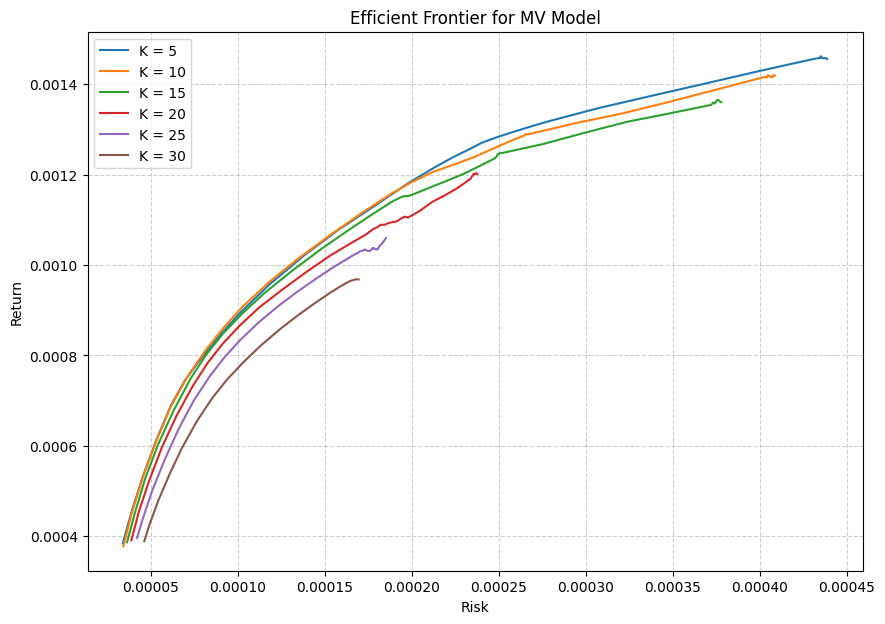

In [49]:
compute_charts_table(K_range_HS, hanseng_rets, "MV")

K=5, Lambda=0.00 completed
K=5, Lambda=0.02 completed
K=5, Lambda=0.04 completed
K=5, Lambda=0.06 completed
K=5, Lambda=0.08 completed
K=5, Lambda=0.10 completed
K=5, Lambda=0.12 completed
K=5, Lambda=0.14 completed
K=5, Lambda=0.16 completed
K=5, Lambda=0.18 completed
K=5, Lambda=0.20 completed
K=5, Lambda=0.22 completed
K=5, Lambda=0.24 completed
K=5, Lambda=0.27 completed
K=5, Lambda=0.29 completed
K=5, Lambda=0.31 completed
K=5, Lambda=0.33 completed
K=5, Lambda=0.35 completed
K=5, Lambda=0.37 completed
K=5, Lambda=0.39 completed
K=5, Lambda=0.41 completed
K=5, Lambda=0.43 completed
K=5, Lambda=0.45 completed
K=5, Lambda=0.47 completed
K=5, Lambda=0.49 completed
K=5, Lambda=0.51 completed
K=5, Lambda=0.53 completed
K=5, Lambda=0.55 completed
K=5, Lambda=0.57 completed
K=5, Lambda=0.59 completed
K=5, Lambda=0.61 completed
K=5, Lambda=0.63 completed
K=5, Lambda=0.65 completed
K=5, Lambda=0.67 completed
K=5, Lambda=0.69 completed
K=5, Lambda=0.71 completed
K=5, Lambda=0.73 completed
K

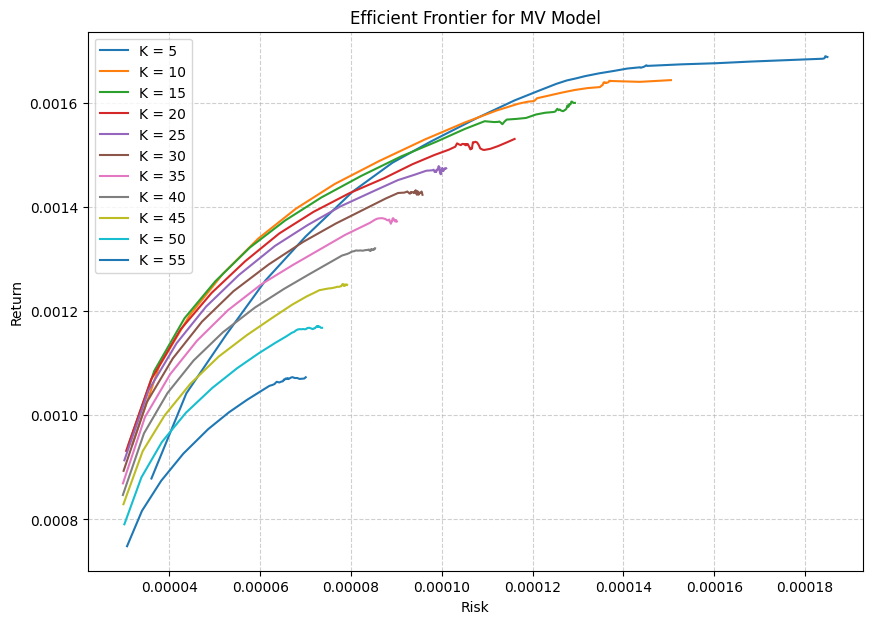

K=5, Lambda=0.00 completed
K=5, Lambda=0.02 completed
K=5, Lambda=0.04 completed
K=5, Lambda=0.06 completed
K=5, Lambda=0.08 completed
K=5, Lambda=0.10 completed
K=5, Lambda=0.12 completed
K=5, Lambda=0.14 completed
K=5, Lambda=0.16 completed
K=5, Lambda=0.18 completed
K=5, Lambda=0.20 completed
K=5, Lambda=0.22 completed
K=5, Lambda=0.24 completed
K=5, Lambda=0.27 completed
K=5, Lambda=0.29 completed
K=5, Lambda=0.31 completed
K=5, Lambda=0.33 completed
K=5, Lambda=0.35 completed
K=5, Lambda=0.37 completed
K=5, Lambda=0.39 completed
K=5, Lambda=0.41 completed
K=5, Lambda=0.43 completed
K=5, Lambda=0.45 completed
K=5, Lambda=0.47 completed
K=5, Lambda=0.49 completed
K=5, Lambda=0.51 completed
K=5, Lambda=0.53 completed
K=5, Lambda=0.55 completed
K=5, Lambda=0.57 completed
K=5, Lambda=0.59 completed
K=5, Lambda=0.61 completed
K=5, Lambda=0.63 completed
K=5, Lambda=0.65 completed
K=5, Lambda=0.67 completed
K=5, Lambda=0.69 completed
K=5, Lambda=0.71 completed
K=5, Lambda=0.73 completed
K

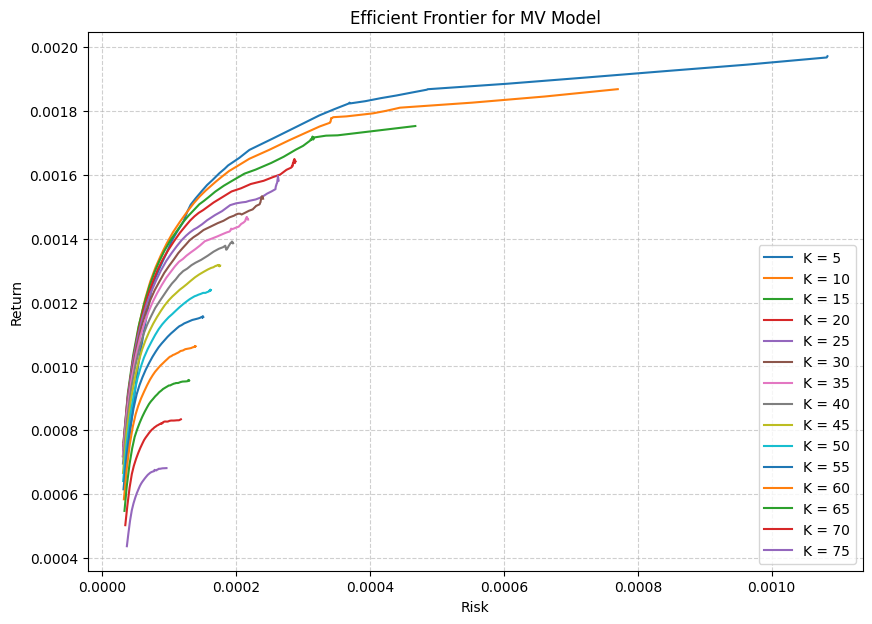

In [51]:
compute_charts_table(K_range_SP, sp_rets, "MV")

K=5, Lambda=0.00 completed
K=5, Lambda=0.02 completed
K=5, Lambda=0.04 completed
K=5, Lambda=0.06 completed
K=5, Lambda=0.08 completed
K=5, Lambda=0.10 completed
K=5, Lambda=0.12 completed
K=5, Lambda=0.14 completed
K=5, Lambda=0.16 completed
K=5, Lambda=0.18 completed
K=5, Lambda=0.20 completed
K=5, Lambda=0.22 completed
K=5, Lambda=0.24 completed
K=5, Lambda=0.27 completed
K=5, Lambda=0.29 completed
K=5, Lambda=0.31 completed
K=5, Lambda=0.33 completed
K=5, Lambda=0.35 completed
K=5, Lambda=0.37 completed
K=5, Lambda=0.39 completed
K=5, Lambda=0.41 completed
K=5, Lambda=0.43 completed
K=5, Lambda=0.45 completed
K=5, Lambda=0.47 completed
K=5, Lambda=0.49 completed
K=5, Lambda=0.51 completed
K=5, Lambda=0.53 completed
K=5, Lambda=0.55 completed
K=5, Lambda=0.57 completed
K=5, Lambda=0.59 completed
K=5, Lambda=0.61 completed
K=5, Lambda=0.63 completed
K=5, Lambda=0.65 completed
K=5, Lambda=0.67 completed
K=5, Lambda=0.69 completed
K=5, Lambda=0.71 completed
K=5, Lambda=0.73 completed
K

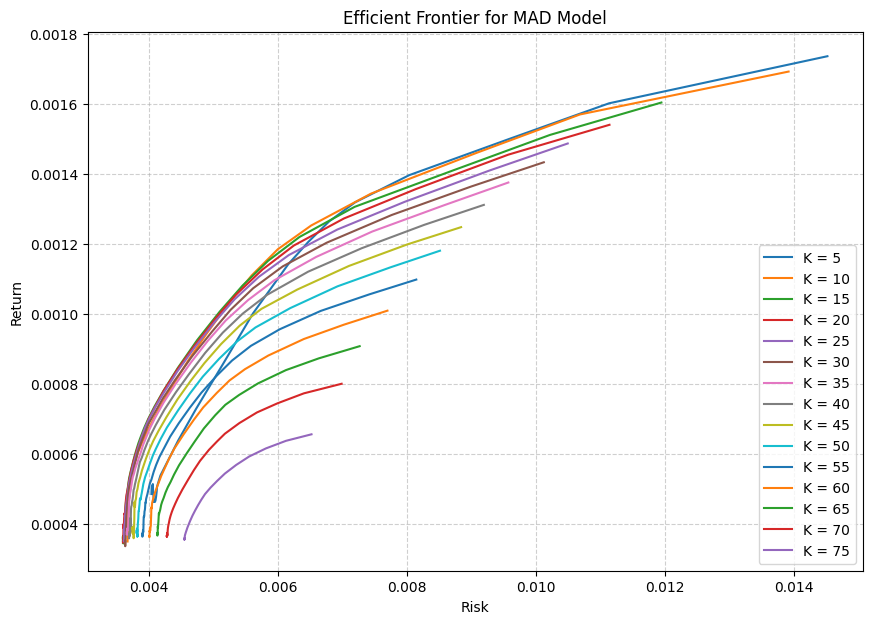

In [52]:
compute_charts_table(K_range_SP, sp_rets, "MAD")

K=5, Lambda=0.00 completed
K=5, Lambda=0.02 completed
K=5, Lambda=0.04 completed
K=5, Lambda=0.06 completed
K=5, Lambda=0.08 completed
K=5, Lambda=0.10 completed
K=5, Lambda=0.12 completed
K=5, Lambda=0.14 completed
K=5, Lambda=0.16 completed
K=5, Lambda=0.18 completed
K=5, Lambda=0.20 completed
K=5, Lambda=0.22 completed
K=5, Lambda=0.24 completed
K=5, Lambda=0.27 completed
K=5, Lambda=0.29 completed
K=5, Lambda=0.31 completed
K=5, Lambda=0.33 completed
K=5, Lambda=0.35 completed
K=5, Lambda=0.37 completed
K=5, Lambda=0.39 completed
K=5, Lambda=0.41 completed
K=5, Lambda=0.43 completed
K=5, Lambda=0.45 completed
K=5, Lambda=0.47 completed
K=5, Lambda=0.49 completed
K=5, Lambda=0.51 completed
K=5, Lambda=0.53 completed
K=5, Lambda=0.55 completed
K=5, Lambda=0.57 completed
K=5, Lambda=0.59 completed
K=5, Lambda=0.61 completed
K=5, Lambda=0.63 completed
K=5, Lambda=0.65 completed
K=5, Lambda=0.67 completed
K=5, Lambda=0.69 completed
K=5, Lambda=0.71 completed
K=5, Lambda=0.73 completed
K

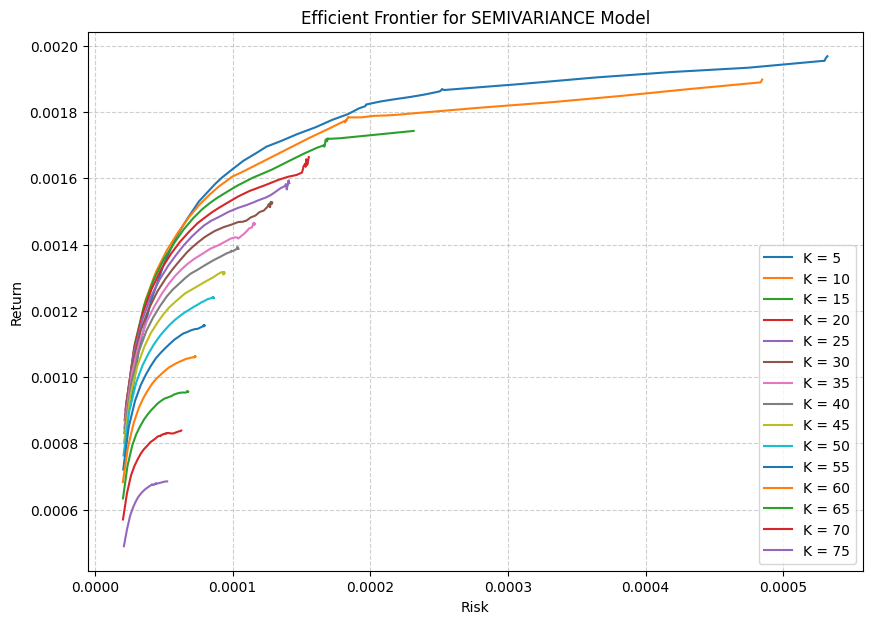

In [53]:
compute_charts_table(K_range_SP, sp_rets, "semivariance")

In [ ]:
compute_charts_table(K_range_SP, sp_rets, "skewness")

K=5, Lambda=0.00 completed
K=5, Lambda=0.02 completed
K=5, Lambda=0.04 completed
K=5, Lambda=0.06 completed
K=5, Lambda=0.08 completed
K=5, Lambda=0.10 completed
K=5, Lambda=0.12 completed
K=5, Lambda=0.14 completed
K=5, Lambda=0.16 completed
K=5, Lambda=0.18 completed
K=5, Lambda=0.20 completed
K=5, Lambda=0.22 completed
K=5, Lambda=0.24 completed
K=5, Lambda=0.27 completed
K=5, Lambda=0.29 completed
K=5, Lambda=0.31 completed
K=5, Lambda=0.33 completed
K=5, Lambda=0.35 completed
K=5, Lambda=0.37 completed
K=5, Lambda=0.39 completed
K=5, Lambda=0.41 completed
K=5, Lambda=0.43 completed
K=5, Lambda=0.45 completed
K=5, Lambda=0.47 completed
K=5, Lambda=0.49 completed
K=5, Lambda=0.51 completed
K=5, Lambda=0.53 completed
K=5, Lambda=0.55 completed
K=5, Lambda=0.57 completed
